In [157]:
## which state has the most sightings? over time?
## most frequent shape by state?
## timeline changes? trends?
## sighting density around airports/afb

In [158]:
import os
import pandas as pd
import json
import requests
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st2
import gmaps
from datetime import date
import holidays
import plotly.graph_objects as go

from keys import g_key

In [159]:
 os.getcwd()

'C:\\Users\\bmoya\\OneDrive\\Documents\\All_My_Repos\\Project 1\\Project-1'

In [160]:
ufo_df = pd.read_csv('resources/ufo2.csv', low_memory=False)


In [161]:
nRow, nCol = ufo_df.shape
print(f'This csv has {nRow} rows and {nCol} columns')

This csv has 70387 rows and 12 columns


In [162]:
#split datetime into date and time and move them to the front of the df

ufo_df[['date', 'time']] = ufo_df.datetime.str.split(' ', expand=True)

#ufo_df2['date'] = pd.to_datetime(ufo_df2.date, infer_datetime_format = True)
#display(ufo_df2.head())

first_column = ufo_df.pop('time')
ufo_df.insert(0, 'time', first_column)

first_column = ufo_df.pop('date')
ufo_df.insert(0, 'date', first_column)

ufo_df.pop('datetime')



ufo_df.head()

,date,time,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,region
0,5/8/2014,0:00,memphis,tn,us,rectangle,900,15 minutes,Standing at my window around 0:00 brilliantly ...,5/8/2014,35.149444,-90.048889,Southeast
1,5/7/2014,23:30,san isidro,nm,us,unknown,15,15 seconds,2 red lights gliding across sky&#44 then green...,5/8/2014,35.563363,-106.770591,Southwest
2,5/7/2014,21:20,hillsboro,mo,us,fireball,360,4-6 minutes,Round slow moving silent ball looked like a ca...,5/8/2014,38.232222,-90.562778,Midwest
3,5/7/2014,21:10,naugatuck,ct,us,unknown,300,5 minutes,Large formation of lights in western sky&#44 f...,5/8/2014,41.485833,-73.051111,Northeast
4,5/7/2014,21:00,theodore,al,us,circle,120,few minutes,Driving home and entered my neighborhood and s...,5/8/2014,30.547500,-88.175278,Southeast


In [163]:
ufo_df['datetime64'] = pd.to_datetime(ufo_df.date, infer_datetime_format = True)
display(ufo_df.head())

ufo_df.sort_values(by=['datetime64'])

,date,time,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,region,datetime64
0,5/8/2014,0:00,memphis,tn,us,rectangle,900,15 minutes,Standing at my window around 0:00 brilliantly ...,5/8/2014,35.149444,-90.048889,Southeast,2014-05-08
1,5/7/2014,23:30,san isidro,nm,us,unknown,15,15 seconds,2 red lights gliding across sky&#44 then green...,5/8/2014,35.563363,-106.770591,Southwest,2014-05-07
2,5/7/2014,21:20,hillsboro,mo,us,fireball,360,4-6 minutes,Round slow moving silent ball looked like a ca...,5/8/2014,38.232222,-90.562778,Midwest,2014-05-07
3,5/7/2014,21:10,naugatuck,ct,us,unknown,300,5 minutes,Large formation of lights in western sky&#44 f...,5/8/2014,41.485833,-73.051111,Northeast,2014-05-07
4,5/7/2014,21:00,theodore,al,us,circle,120,few minutes,Driving home and entered my neighborhood and s...,5/8/2014,30.547500,-88.175278,Southeast,2014-05-07


,date,time,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,region,datetime64
70386,6/1/1910,15:00,wills point,tx,us,cigar,120,2 minutes,Cigar shaped object moving from West to East,4/16/2005,32.709167,-96.008056,Southwest,1910-06-01
70385,6/11/1920,21:00,cicero,in,us,unknown,60,1 minute,((NUFORC Note: Probable hoax. Note date. PD...,5/12/2009,40.123889,-86.013333,Midwest,1920-06-11
70384,12/28/1925,18:00,atkinson (6 miles north of),il,us,disk,60,1 minute,Young boy witnesses disc in sky above Illinois...,5/11/2005,41.420833,-90.015000,Midwest,1925-12-28
70383,7/5/1929,14:00,buchanan (or burns),or,us,disk,60,1min,we were traveling east of burns&#44clmbing up ...,8/16/2002,43.642500,-118.627500,West,1929-07-05
70382,6/1/1930,22:00,ithaca/freeville,ny,us,triangle,1200,20 mins,Very Large Triangle Shapped Object,1/19/2005,42.509167,-76.393804,Northeast,1930-06-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,5/7/2014,9:30,port richey,fl,us,unknown,1,1 second,Sonic boom denied by military source per McDil...,5/8/2014,28.271389,-82.719722,Southeast,2014-05-07
11,5/7/2014,3:30,calera,al,us,circle,240,3-4 minutes,Orange/red sphere with blue or green outline o...,5/8/2014,33.102778,-86.753611,Southeast,2014-05-07
12,5/7/2014,0:00,detroit,mi,us,fireball,180,3 minutes,Fire balls in detroit sky.,5/8/2014,42.331389,-83.045833,Midwest,2014-05-07
6,5/7/2014,20:30,visalia,ca,us,fireball,180,3 minutes,Strange&#44 slowly moving fireball like object...,5/8/2014,36.330278,-119.291111,West,2014-05-07


In [164]:
#convert 'duration' column from object to float64

ufo_df.rename(columns = {'duration (seconds)':'duration_sec'}, inplace = True)

ufo_df["duration_sec"] = pd.to_numeric(ufo_df.duration_sec, errors='coerce')

ufo_df['year'] = pd.DatetimeIndex(ufo_df['datetime64']).year
ufo_df['month'] = pd.DatetimeIndex(ufo_df['datetime64']).month
ufo_df['day'] = pd.DatetimeIndex(ufo_df['datetime64']).day
ufo_df['weekday'] = pd.DatetimeIndex(ufo_df['datetime64']).day_name()
ufo_df.head()

,date,time,city,state,country,shape,duration_sec,duration (hours/min),comments,date posted,latitude,longitude,region,datetime64,year,month,day,weekday
0,5/8/2014,0:00,memphis,tn,us,rectangle,900.0,15 minutes,Standing at my window around 0:00 brilliantly ...,5/8/2014,35.149444,-90.048889,Southeast,2014-05-08,2014,5,8,Thursday
1,5/7/2014,23:30,san isidro,nm,us,unknown,15.0,15 seconds,2 red lights gliding across sky&#44 then green...,5/8/2014,35.563363,-106.770591,Southwest,2014-05-07,2014,5,7,Wednesday
2,5/7/2014,21:20,hillsboro,mo,us,fireball,360.0,4-6 minutes,Round slow moving silent ball looked like a ca...,5/8/2014,38.232222,-90.562778,Midwest,2014-05-07,2014,5,7,Wednesday
3,5/7/2014,21:10,naugatuck,ct,us,unknown,300.0,5 minutes,Large formation of lights in western sky&#44 f...,5/8/2014,41.485833,-73.051111,Northeast,2014-05-07,2014,5,7,Wednesday
4,5/7/2014,21:00,theodore,al,us,circle,120.0,few minutes,Driving home and entered my neighborhood and s...,5/8/2014,30.547500,-88.175278,Southeast,2014-05-07,2014,5,7,Wednesday


In [165]:
ufo_df.describe()

,duration_sec,latitude,longitude,year,month,day
count,7.038500e+04,70387.000000,70387.000000,70387.000000,70387.000000,70387.000000
mean,5.519464e+03,38.319925,-95.534165,2003.984486,6.862702,14.984372
std,3.905478e+05,5.739533,18.789725,10.444505,3.243579,8.919110
min,1.000000e-03,-46.163992,-170.478889,1910.000000,1.000000,1.000000
25%,3.000000e+01,34.108333,-114.703333,2001.000000,4.000000,7.000000
50%,1.800000e+02,38.953611,-89.966389,2007.000000,7.000000,15.000000
75%,6.000000e+02,41.929444,-80.830000,2011.000000,10.000000,22.000000
max,6.627600e+07,71.387500,169.875050,2014.000000,12.000000,31.000000


In [166]:
ufo_df.dtypes

date                            object
time                            object
city                            object
state                           object
country                         object
shape                           object
duration_sec                   float64
duration (hours/min)            object
comments                        object
date posted                     object
latitude                       float64
longitude                      float64
region                          object
datetime64              datetime64[ns]
year                             int64
month                            int64
day                              int64
weekday                         object
dtype: object

In [167]:
ufo_df['shape'].value_counts().head()

light       14576
triangle     7043
circle       6555
fireball     5529
unknown      4944
Name: shape, dtype: int64

In [168]:
ufo_df['state'].value_counts().head()

ca    9584
wa    4240
fl    4175
tx    3638
ny    3195
Name: state, dtype: int64

In [169]:
ufo_df.nunique()

date                    10103
time                     1374
city                    15354
state                      52
country                     1
shape                      28
duration_sec              490
duration (hours/min)     7297
comments                70117
date posted               315
latitude                15174
longitude               15968
region                      5
datetime64              10103
year                       85
month                      12
day                        31
weekday                     7
dtype: int64

In [170]:
top_dates=ufo_df[['month','day']].value_counts().reset_index(name='count')
top_dates

,month,day,count
0,7,4,1180
1,6,1,938
2,6,15,750
3,7,15,718
4,8,15,651
...,...,...,...
361,3,4,109
362,5,2,106
363,1,30,104
364,5,9,103


In [171]:
july_fourth=top_dates.iloc[0:1]
july_fourth

,month,day,count
0,7,4,1180


In [172]:
df = (july_fourth['count'] /top_dates['count'].sum()) * 100
df

0    1.676446
Name: count, dtype: float64

In [173]:
bins = [1940, 1959, 1969, 1979, 1989, 1999, 2009, 2015]


labels = ['1950-1959', '1960-1969', '1970-1979', '1980-1989','1990-1999','2000-2009','2010-2015']

ufo_df['Date Bin'] = pd.cut(ufo_df.year, bins, labels=labels, right=False)

date_shape = ufo_df.groupby(['Date Bin']).size().reset_index(name='count')
date_shape

         

,Date Bin,count
0,1950-1959,421
1,1960-1969,1066
2,1970-1979,1981
3,1980-1989,1773
4,1990-1999,5843
5,2000-2009,31552
6,2010-2015,27737


In [174]:
date_shape = ufo_df.groupby(['Date Bin']).size()
date_shape

Date Bin
1950-1959      421
1960-1969     1066
1970-1979     1981
1980-1989     1773
1990-1999     5843
2000-2009    31552
2010-2015    27737
dtype: int64

In [175]:
bins = [1940, 1959, 1969, 1979, 1989, 1999, 2010]


labels = ['1950-1959','1960-1969','1970-1979','1980-1989','1990-1999','2000-2010']

ufo_df['Date Bin'] = pd.cut(ufo_df.datetime64.dt.year, bins, labels=labels, right=False)

date_region = ufo_df.groupby(['Date Bin','region']).size().reset_index(name='count').set_index('region')
date_region.head()


,Date Bin,count
region,,
Midwest,1950-1959,88
Northeast,1950-1959,93
Southeast,1950-1959,53
Southwest,1950-1959,70
West,1950-1959,116


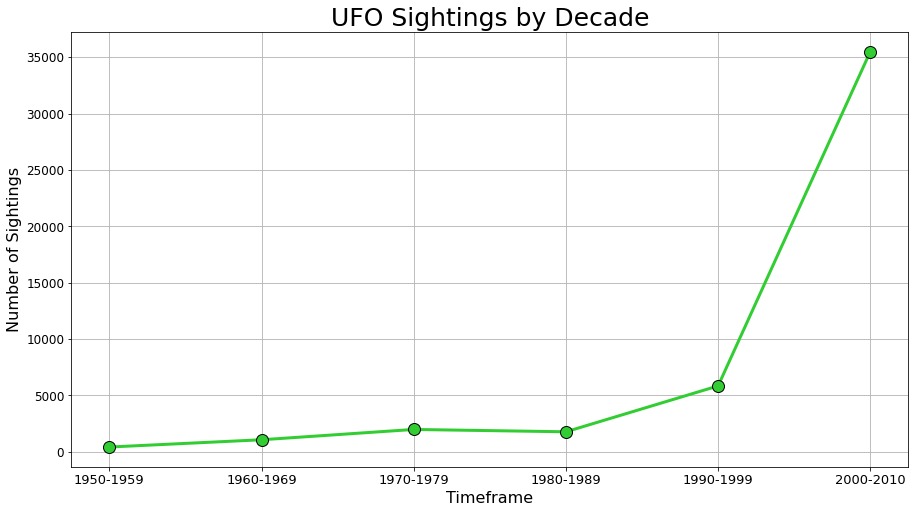

In [176]:
sightings_time = ufo_df['Date Bin'].value_counts()
sightings_time = pd.DataFrame(sightings_time)
sightings_time = sightings_time.reset_index()
sightings_time = sightings_time.sort_values('index')
sightings_time = sightings_time.set_index('index')
sightings_time.plot(kind='line',color="limegreen",marker = 'o',markeredgecolor='black',markersize=12,linewidth=3,figsize=(15,8),legend=False,grid=True,)
plt.xticks(size=13, rotation=0)
plt.yticks(size=12)
plt.ylabel("Number of Sightings", size=16)
plt.xlabel("Timeframe", size=16)
plt.title("UFO Sightings by Decade", size=25)
plt.show()


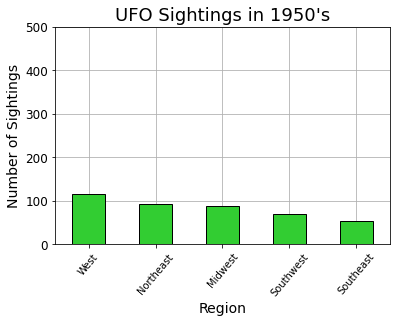

In [177]:
fifty_df = date_region.loc[date_region['Date Bin'] == '1950-1959'].sort_values(by = ['count'], ascending = False)
fifty_df.plot(kind = "bar",color="limegreen",zorder=5,grid=True,legend=False,edgecolor="black")
plt.xticks(size=10, rotation=50)
plt.yticks(size=12)
plt.ylabel("Number of Sightings", size=14)
plt.xlabel("Region", size=14)
plt.title("UFO Sightings in 1950's", size=18)
axes = plt.gca()
axes.set_ylim([0,500])
plt.savefig("Images/1950img.png")



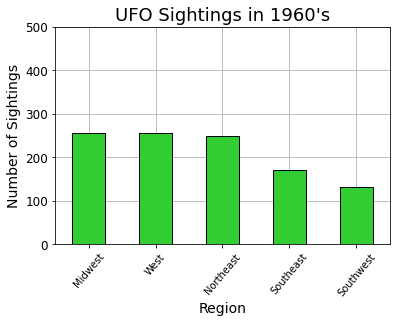

In [178]:
sixty_df = date_region.loc[date_region['Date Bin'] == '1960-1969'].sort_values(by = ['count'], ascending = False)
sixty_df.plot(kind = "bar",color="limegreen",zorder=5,grid=True,legend=False,edgecolor="black")
plt.xticks(size=10, rotation=50)
plt.yticks(size=12)
plt.ylabel("Number of Sightings", size=14)
plt.xlabel("Region", size=14)
plt.title("UFO Sightings in 1960's", size=18)
axes = plt.gca()
axes.set_ylim([0,500])
plt.savefig("Images/1960img.png")

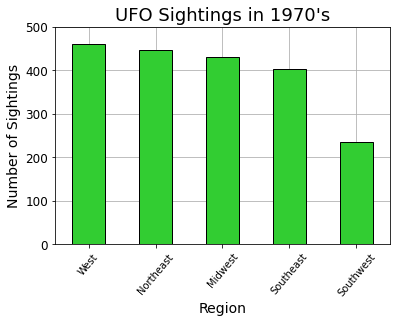

In [179]:
seventy_df = date_region.loc[date_region['Date Bin'] == '1970-1979'].sort_values(by = ['count'], ascending = False)
seventy_df.plot(kind = "bar",color="limegreen",zorder=5,grid=True,legend=False,edgecolor="black")
plt.xticks(size=10, rotation=50)
plt.yticks(size=12)
plt.ylabel("Number of Sightings", size=14)
plt.xlabel("Region", size=14)
plt.title("UFO Sightings in 1970's", size=18)
axes = plt.gca()
axes.set_ylim([0,500])

plt.savefig("Images/1970img.png")

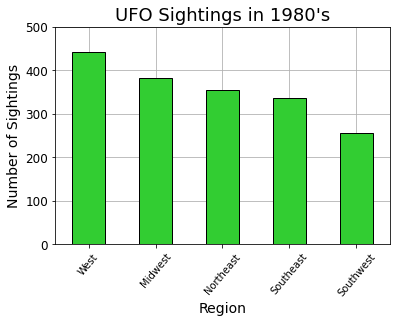

In [180]:
eighty_df = date_region.loc[date_region['Date Bin'] == '1980-1989'].sort_values(by = ['count'], ascending = False)
eighty_df.plot(kind = "bar",color="limegreen",zorder=5,grid=True,legend=False,edgecolor="black")
plt.xticks(size=10, rotation=50)
plt.yticks(size=12)
plt.ylabel("Number of Sightings", size=14)
plt.xlabel("Region", size=14)
plt.title("UFO Sightings in 1980's", size=18)
axes = plt.gca()
axes.set_ylim([0,500])

plt.savefig("Images/1980img.png")

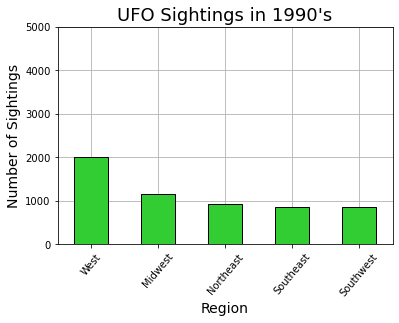

In [181]:
ninty_df = date_region.loc[date_region['Date Bin'] == '1990-1999'].sort_values(by = ['count'], ascending = False)
ninty_df.plot(kind = "bar",color="limegreen",zorder=5,grid=True,legend=False,edgecolor="black")
plt.xticks(size=10, rotation=50)
plt.ylabel("Number of Sightings", size=14)
plt.xlabel("Region", size=14)
plt.title("UFO Sightings in 1990's", size=18)
axes = plt.gca()
axes.set_ylim([0,5000])

plt.savefig("Images/1990img.png")

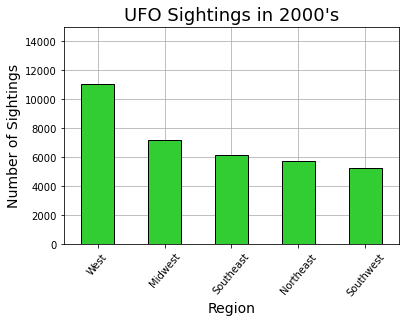

In [182]:
thousands_df = date_region.loc[date_region['Date Bin'] == '2000-2010'].sort_values(by = ['count'], ascending = False)
thousands_df.plot(kind = "bar",color="limegreen",zorder=5,grid=True,legend=False,edgecolor="black")

plt.xticks(size=10, rotation=50)
plt.ylabel("Number of Sightings", size=14)
plt.xlabel("Region", size=14)
plt.title("UFO Sightings in 2000's", size=18)

axes = plt.gca()
axes.set_ylim([0,15000])

plt.savefig("Images/1990img.png")

In [183]:
region_map = ufo_df.groupby(['state','latitude','longitude','region']).size().reset_index(name='count')
region_map

,state,latitude,longitude,region,count
0,ak,-22.690615,-43.238749,West,1
1,ak,5.942987,-56.992517,West,1
2,ak,54.800685,-131.440430,West,1
3,ak,55.185833,-162.721111,West,1
4,ak,55.342222,-131.646111,West,7
...,...,...,...,...,...
16568,wy,44.883333,-108.468889,West,1
16569,wy,44.899444,-109.150278,West,6
16570,wy,44.998823,-110.693530,West,1
16571,wy,52.247855,20.981427,West,1


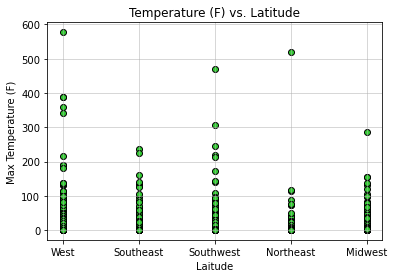

In [184]:
plt.scatter(region_map["region"], region_map["count"],facecolor = "limegreen", edgecolor = "black")
plt.title("Temperature (F) vs. Latitude")
plt.xlabel("Laitude")
plt.ylabel("Max Temperature (F)")
plt.grid(linestyle='-', linewidth=1, alpha = 0.5)

plt.show()

